In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
# Inspect all columns and dtypes for measurement.
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
# Inspect all columns and dtypes for station.
inspector = inspect(engine)
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

## Precipitation Analysis

In [12]:
# # Query how the dates are formatted
# dates = session.query(Measurement.date).limit(1).all()
# for date in dates:
#     print(result)

In [21]:
# Query the most recent date in dataset.
# Convert to datetime object for calculation below.
max_date = session.query(func.max(func.strftime("%Y-%m-%d", Measurement.date))).limit(1).all()
max_date = max_date[0][0]
max_date = dt.datetime.strptime(max_date, "%Y-%m-%d")
max_date

datetime.datetime(2017, 8, 23, 0, 0)

In [26]:
# Calculate the date 1 year ago from the last data point in the database
year_ago = max_date - dt.timedelta(days=366)
year_ago

datetime.datetime(2016, 8, 22, 0, 0)

In [32]:
# Perform a query to retrieve the last 12 months of precipitation data.
precipitations = session.query(func.strftime("%Y-%m-%d", Measurement.date), Measurement.prcp).\
        filter(func.strftime("%Y-%m-%d", Measurement.date) >= year_ago).all()
# precipitations

In [33]:
# Save the query results as a Pandas DataFrame and set the index to the date column
df_precipitation = pd.DataFrame(precipitations, columns=['Date', 'Precipitation'])
# df_precipitation

# Dataframe sorted by date, set index to date.
df_precipitation = df_precipitation.sort_values(by = 'Date')
df_precipitation.set_index('Date', inplace=True)
# df_precipitation.head()
df_precipitation.tail()

,Precipitation
Date,
2017-08-22,0.00
2017-08-23,0.00
2017-08-23,0.00
2017-08-23,0.08
2017-08-23,0.45


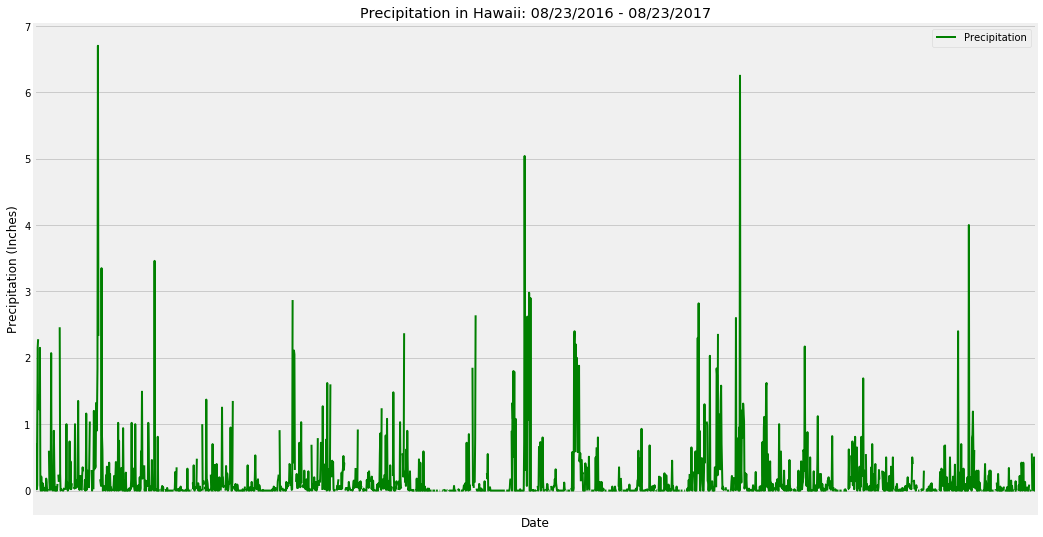

In [34]:
# Use Pandas Plotting with Matplotlib to plot the data
df_precipitation.plot(figsize = (16, 9), sort_columns=True, legend=True, color='g', linewidth=2)
plt.ylabel('Precipitation (Inches)')
plt.xlabel('Date')
plt.xticks([])
plt.grid(True)
plt.title("Precipitation in Hawaii: 08/23/2016 - 08/23/2017")
plt.savefig('Images/precipitation_plot.png')
plt.show()

In [35]:
# Calculate the summary statistics for the precipitation data
df_precipitation.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


## Station Analysis

In [36]:
# Query to show how many stations are available in this dataset.
station_count = session.query(Station.id).count()
station_count

9

In [37]:
# Lists the most active stations from Station DB and their respective count.
# Merge on "station" for Measurement and Station tables.
# Group By Station and list station and counts in Desc order.
most_active_stations = session.query(Station.station, func.count(Station.id)).\
    filter(Measurement.station == Station.station).group_by(Station.station).\
    order_by(func.count(Station.id).desc()).all()
most_active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [38]:
# Locate the most active station id.
most_active_station = most_active_stations[0][0]
most_active_station

'USC00519281'

In [39]:
# Using the most active station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature.
summary_temps = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == most_active_station).all()
summary_temps

[(54.0, 85.0, 71.66378066378067)]

In [41]:
# Choose the station with the highest number of temperature observations
# and query the last 12 months of temp observations.
temperatures = session.query(Measurement.date, Measurement.tobs).filter(Measurement.station == most_active_station).\
    filter(func.strftime("%Y-%m-%d", Measurement.date) >= year_ago).all()
# temperatures

In [44]:
# Load 12 months of temp. data for most active station into Pandas DF.
# Set index to Date.
df_temperature = pd.DataFrame(temperatures, columns=['Date', 'Temperature'])
df_temperature.set_index('Date', inplace=True)
df_temperature.head()

,Temperature
Date,
2016-08-23,77.0
2016-08-24,77.0
2016-08-25,80.0
2016-08-26,80.0
2016-08-27,75.0


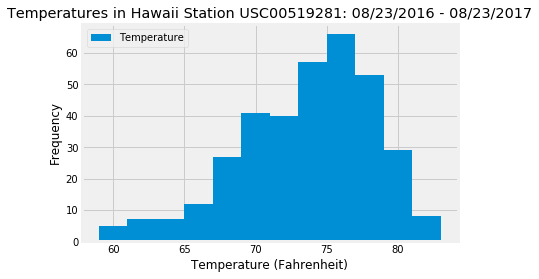

In [45]:
# Plot results for Station USC00519281 as histogram with 12 bins.
fig, ax = plt.subplots()
df_temperature.plot.hist(bins = 12, ax = ax, legend=True)

# Set labels
ax.set_xlabel('Temperature (Fahrenheit)')
ax.set_ylabel('Frequency')
ax.set_title('Temperatures in Hawaii Station USC00519281: 08/23/2016 - 08/23/2017')

# Save figure
plt.savefig("Images/temperature_histogram.png")
plt.show()

In [55]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [61]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
# Trip dates = 2017-08-01 - 2017-08-05: Utilize available data from 2017.
trip_temperatures = calc_temps('2017-08-01', '2017-08-05')
trip_temperatures

[(72.0, 78.42105263157895, 83.0)]

<IPython.core.display.Javascript object>


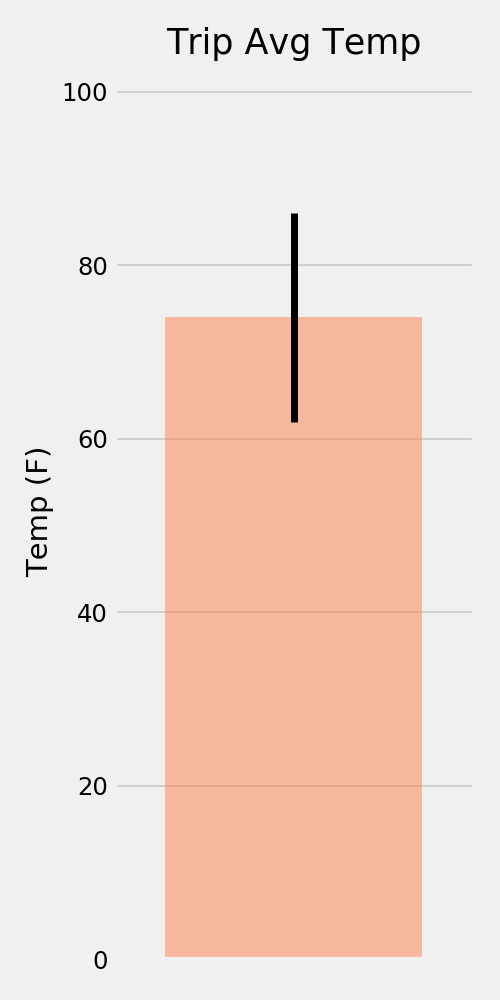

In [18]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [19]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.31), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.25), ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6, 0.1), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.060000000000000005), ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9, 0.0), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.0), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.0)]


## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


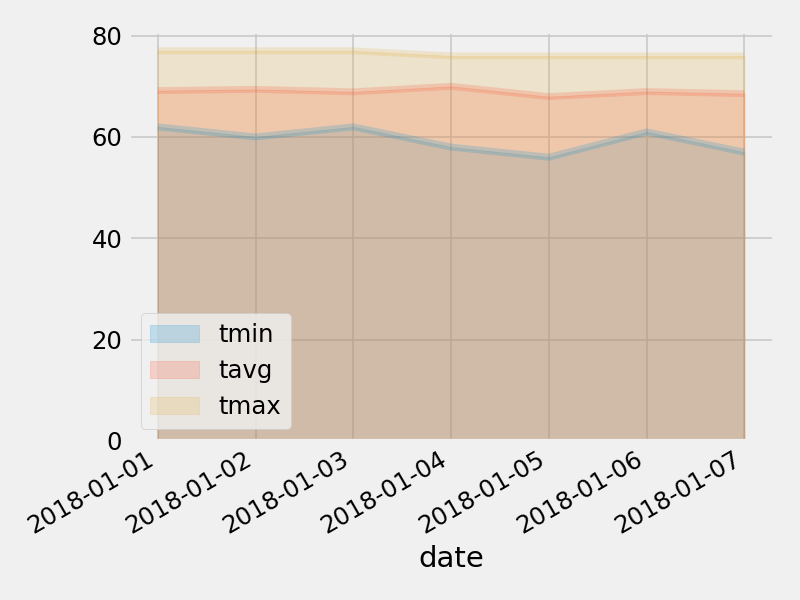

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
